In [1]:
# import all the necessary and plots some graphs for the csv files in the same direcory
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
sns.set(style="darkgrid")
csv_files = glob.glob(os.path.join(os.getcwd(), "*.csv"))



#print the name of the tables found
print("CSV files found in the current directory:")
for file in csv_files:
    print(f"- {os.path.basename(file)}")

# This script reads all CSV files in the current directory, creates line plots for each file, and saves the plots as PNG images.    



CSV files found in the current directory:
- Measurements_Run_09_18.05.2025_2225.csv
- Measurements_Run_10_18.05.2025_2230.csv
- Measurements_Run_11_18.05.2025_2234.csv
- Measurements_Run_12_18.05.2025_2245.csv
- Measurements_Run_13_18.05.2025_2252.csv
- Measurements_Run_14_18.05.2025_2258.csv


In [ ]:
# now using sql lite
# the columns are  run_id,timestamp,value,sensor_name
# there are 5 sensors, and they repeat for each run_id and each timestamp
# sensors are Dissolved Oxygen 1 ,Dissolved Oxygen 2, Conductivity Probe ,Temperature (DO Sensor),Depth Sensor
# so now we plot the values for each sensor over time for each run_id
import sqlite3
import re
#table names (the csv files) are:
#- Measurements_Run_09_18.05.2025_2225.csv
#- Measurements_Run_10_18.05.2025_2230.csv
#- Measurements_Run_11_18.05.2025_2234.csv
#- Measurements_Run_12_18.05.2025_2245.csv
#- Measurements_Run_13_18.05.2025_2252.csv
#- Measurements_Run_14_18.05.2025_2258.csv

conn = sqlite3.connect(':memory:')  
cursor = conn.cursor()
# monkeypatch plt.xticks so calling plt.xticks(rotation=45) will keep ~10 timestamp labels evenly spaced
_original_xticks = plt.xticks
import matplotlib.text as mtext

_original_text_get = mtext.Text.get_text
_timestamp_re = re.compile(r'^\d{4}-\d{2}-\d{2}[ T]\d{2}:\d{2}:\d{2}(?:\.\d+)?$')

def _shorten_timestamp_text(self):
    s = _original_text_get(self)
    if isinstance(s, str) and _timestamp_re.match(s):
        # keep only the time part and drop fractional seconds, e.g. "2025-05-18 22:25:57.782168" -> "22:25:57"
        if ' ' in s:
            time_part = s.split(' ', 1)[1]
        else:
            time_part = s.split('T', 1)[1]
        return time_part.split('.', 1)[0]
    return s

mtext.Text.get_text = _shorten_timestamp_text
#timestamp format is 2025-05-18 22:25:59.263827
def _xticks_limited(*args, **kwargs):
    # If user only requests rotation (as in the loop), reduce labels to ~10 evenly spaced ones
    rotation = kwargs.get("rotation", None)
    if not args and rotation is not None:
        ax = plt.gca()
        labels = [t.get_text() for t in ax.get_xticklabels()]
        N = len(labels)
        if N <= 10 or N == 0:
            return _original_xticks(**kwargs)
        # choose ~10 evenly spaced indices across available labels
        indices = sorted({int(round(i * (N - 1) / 9)) for i in range(10)})
        # get tick positions; fallback to indices if positions length differs
        positions = ax.get_xticks()
        if len(positions) == N:
            sel_positions = [positions[i] for i in indices]
        else:
            sel_positions = indices
        sel_labels = [labels[i] for i in indices]
        return _original_xticks(sel_positions, sel_labels, **kwargs)
    return _original_xticks(*args, **kwargs)

plt.xticks = _xticks_limited
for file in csv_files:
    table_name = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file)
    df.to_sql(table_name, conn, index=False, if_exists='replace')
    
    sensors = df['sensor_name'].unique()
    plt.figure(figsize=(12, 8))
    
    for sensor in sensors:
        query = f"SELECT timestamp, value FROM '{table_name}' WHERE sensor_name = ?"
        sensor_df = pd.read_sql_query(query, conn, params=(sensor,))
        #normalize values of Dissolved Oxygen 1 and Dissolved Oxygen 2 and temperature to be between 0 and 200
        #normalize values
        if sensor in ['Dissolved Oxygen 1', 'Dissolved Oxygen 2', 'Temperature (DO Sensor)', 'Conductivity Probe', 'Depth Sensor']:
            min_val = sensor_df['value'].min()
            max_val = sensor_df['value'].max()
            sensor_df['value'] = (sensor_df['value'] - min_val) / (max_val - min_val) * 200     
            
        plt.plot(sensor_df['timestamp'], sensor_df['value'], label=sensor)
    
    plt.title(f"Sensor Data for {table_name}")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

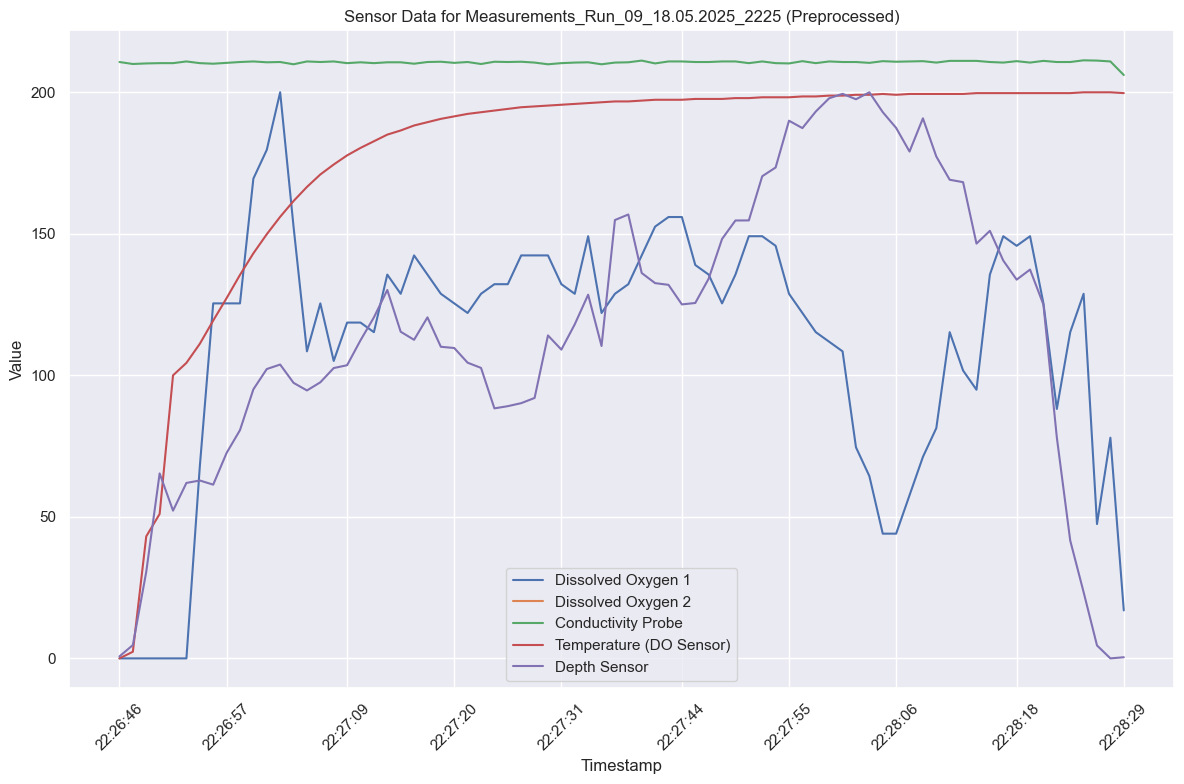

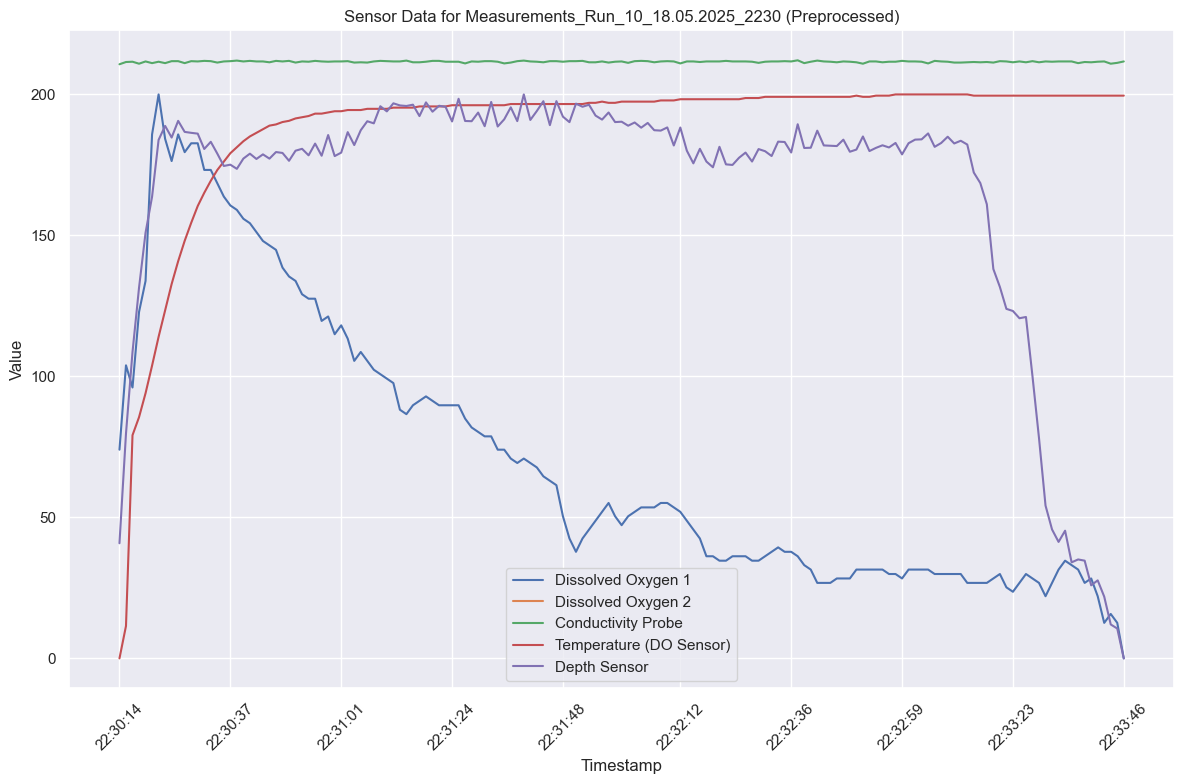

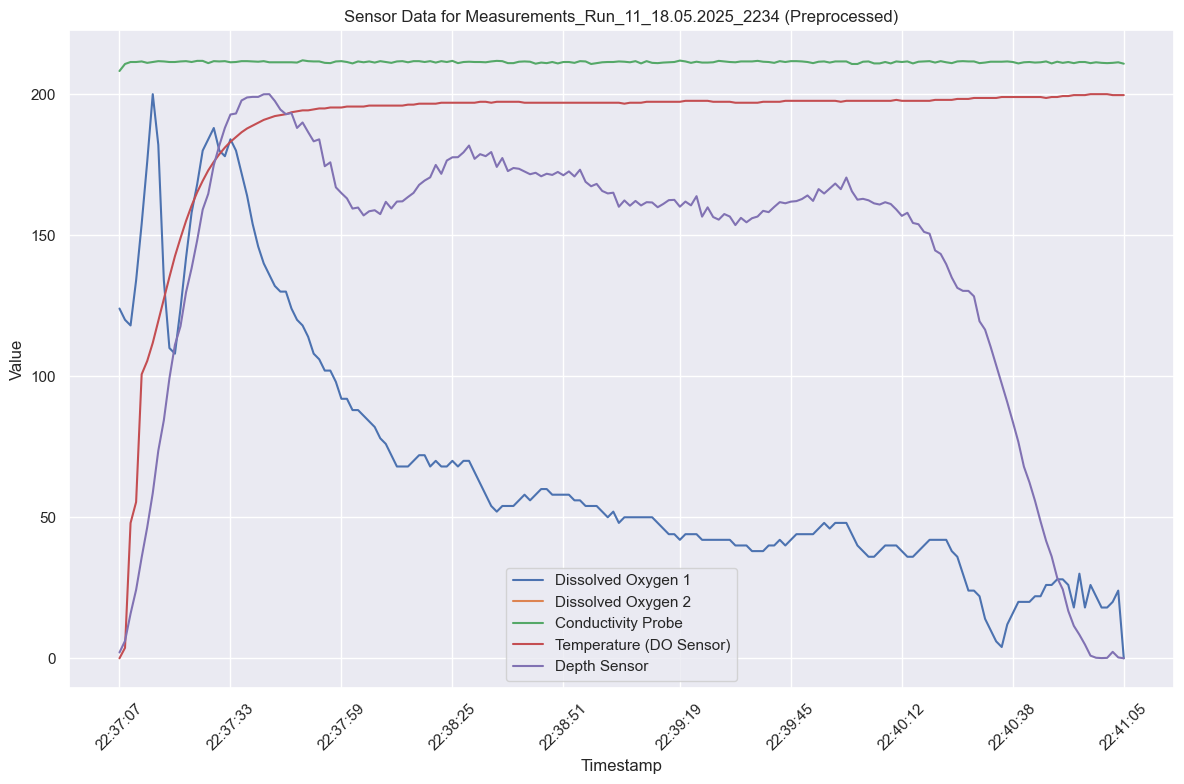

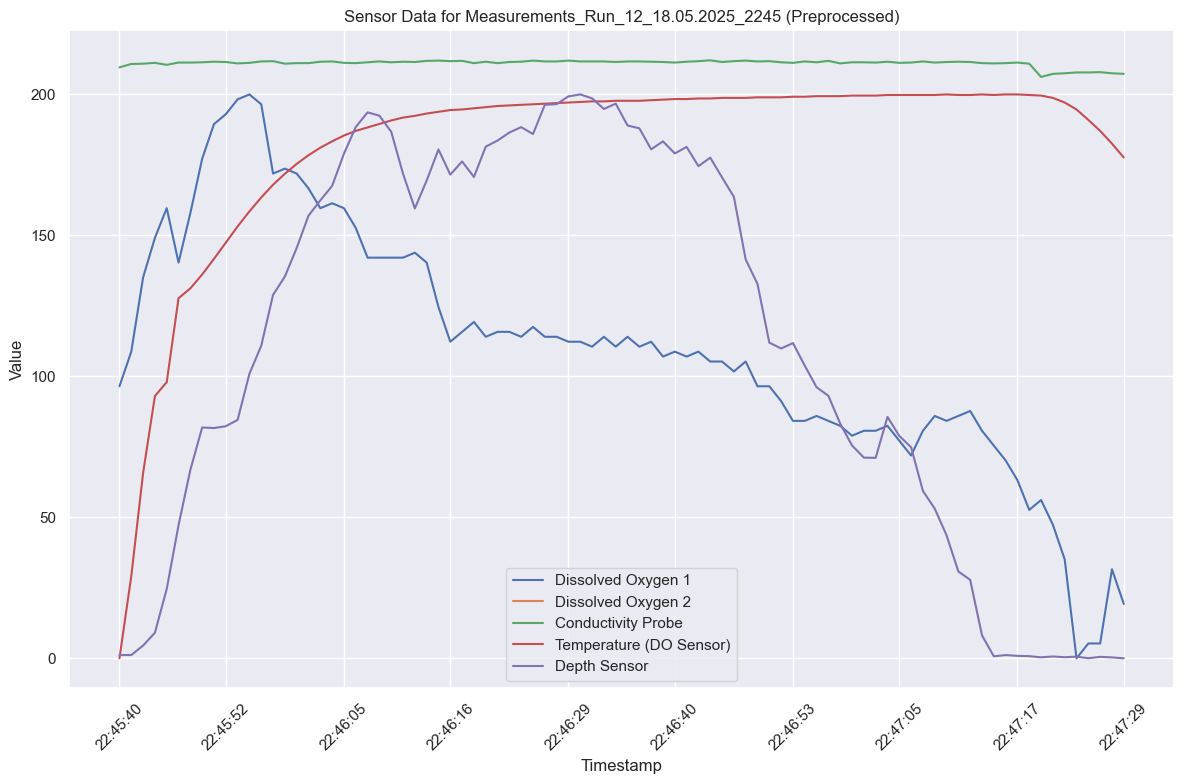

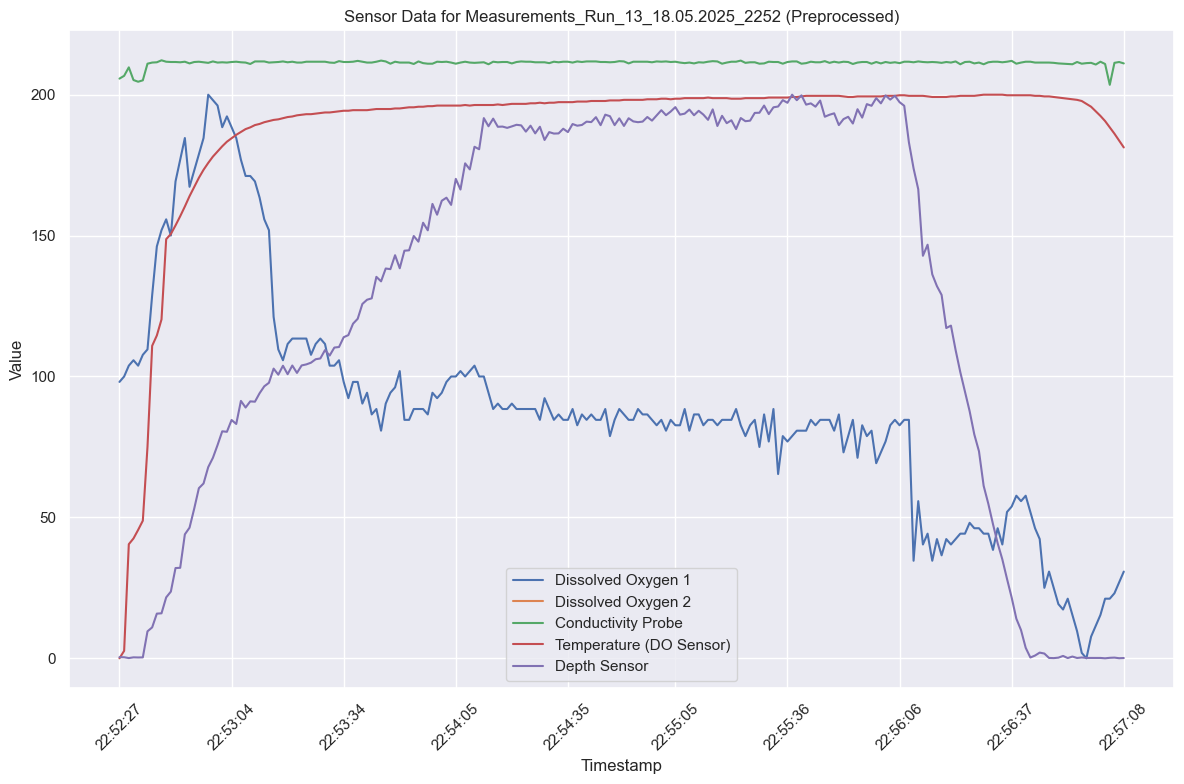

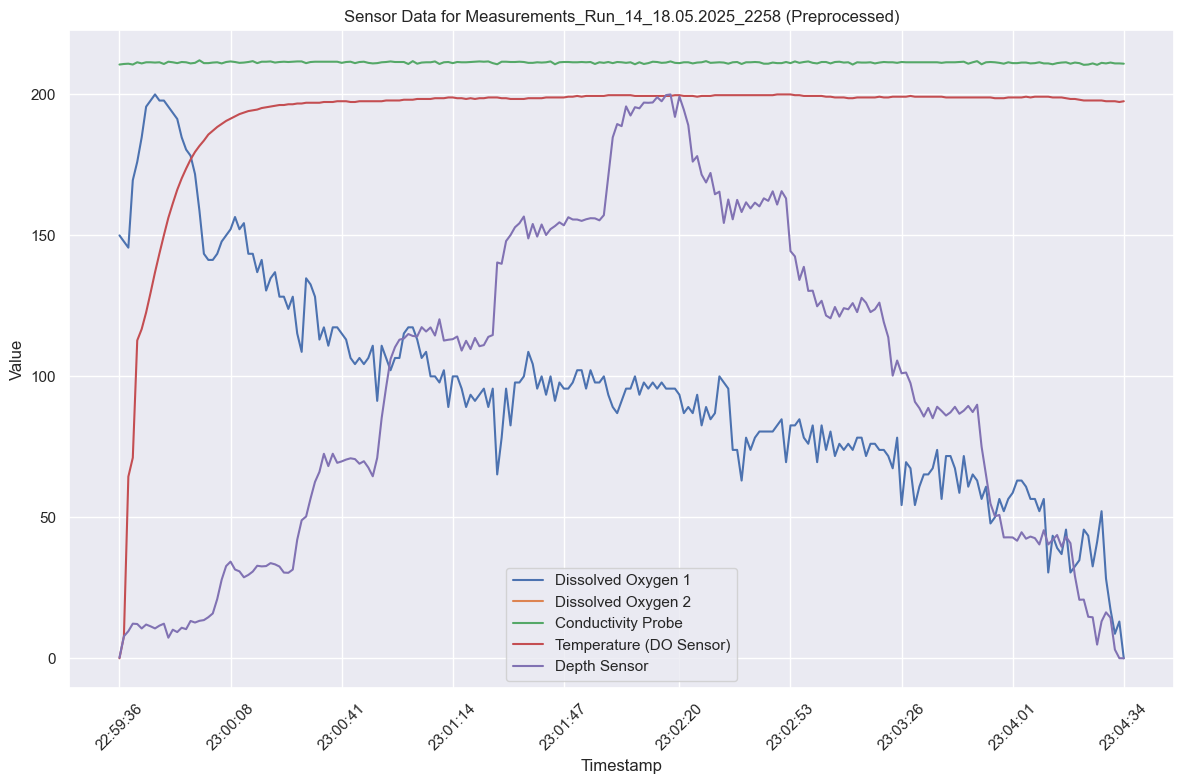

In [6]:
# preprocess data

'''structure of the csv is like :

10,2025-05-18 22:30:32.351321,6.13,Dissolved Oxygen 1
10,2025-05-18 22:30:32.351321,61.92,Dissolved Oxygen 2
10,2025-05-18 22:30:32.351321,211.9,Conductivity Probe
10,2025-05-18 22:30:32.351321,12.604,Temperature (DO Sensor)
10,2025-05-18 22:30:32.351321,2.732344708317479,Depth Sensor
10,2025-05-18 22:30:33.714261,6.13,Dissolved Oxygen 1
10,2025-05-18 22:30:33.714261,61.92,Dissolved Oxygen 2
10,2025-05-18 22:30:33.714261,211.8,Conductivity Probe
10,2025-05-18 22:30:33.714261,12.614,Temperature (DO Sensor)
10,2025-05-18 22:30:33.714261,2.7851687741858666,Depth Sensor
10,2025-05-18 22:30:35.079797,6.1,Dissolved Oxygen 1
10,2025-05-18 22:30:35.079797,61.92,Dissolved Oxygen 2
10,2025-05-18 22:30:35.079797,211.3,Conductivity Probe
10,2025-05-18 22:30:35.079797,12.623,Temperature (DO Sensor)
10,2025-05-18 22:30:35.079797,2.698335412418999,Depth Sensor


'''
# preprocess the data to remove any rows where the Conductivity Probe value is below 200

for file in csv_files:
    table_name = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file)
    # get timestamps where Conductivity Probe value is below 200
    low_cond_timestamps = df[(df['sensor_name'] == 'Conductivity Probe') & (df['value'] < 200)]['timestamp'].unique()
    # remove rows with these timestamps
    df = df[~df['timestamp'].isin(low_cond_timestamps)]
    df.to_sql(table_name, conn, index=False, if_exists='replace')
    
    sensors = df['sensor_name'].unique()
    plt.figure(figsize=(12, 8))
    for sensor in sensors:
        query = f"SELECT timestamp, value FROM '{table_name}' WHERE sensor_name = ?"
        sensor_df = pd.read_sql_query(query, conn, params=(sensor,))
        #normalize values of Dissolved Oxygen 1 and Dissolved Oxygen 2 and temperature to be between 0 and 200
        #normalize values
        if sensor in ['Dissolved Oxygen 1', 'Dissolved Oxygen 2', 'Temperature (DO Sensor)', 'Depth Sensor']:
            min_val = sensor_df['value'].min()
            max_val = sensor_df['value'].max()
            sensor_df['value'] = (sensor_df['value'] - min_val) / (max_val - min_val) * 200     
            
        plt.plot(sensor_df['timestamp'], sensor_df['value'], label=sensor)
    plt.title(f"Sensor Data for {table_name} (Preprocessed)")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

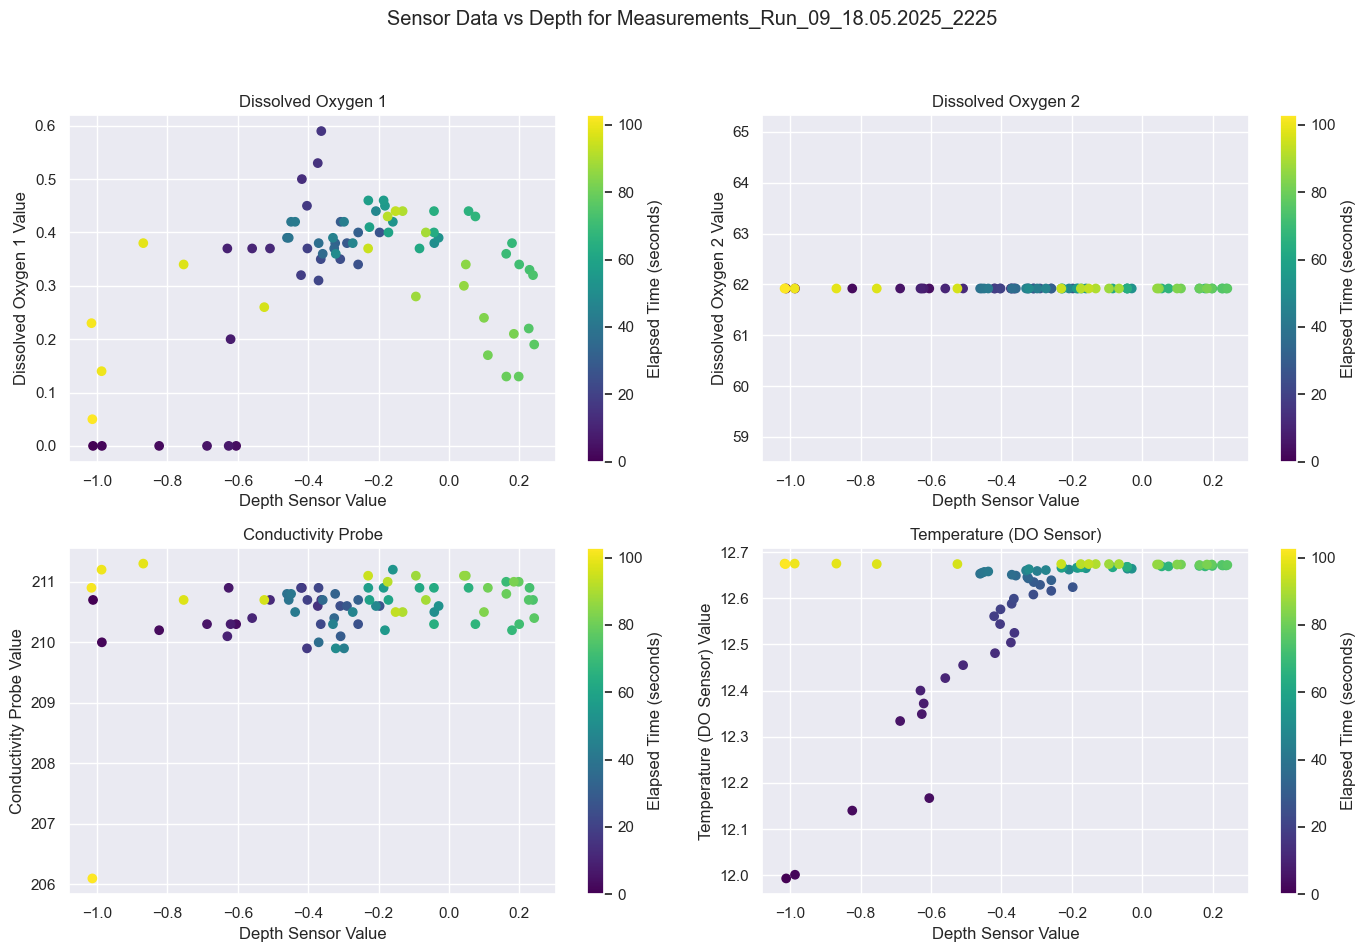

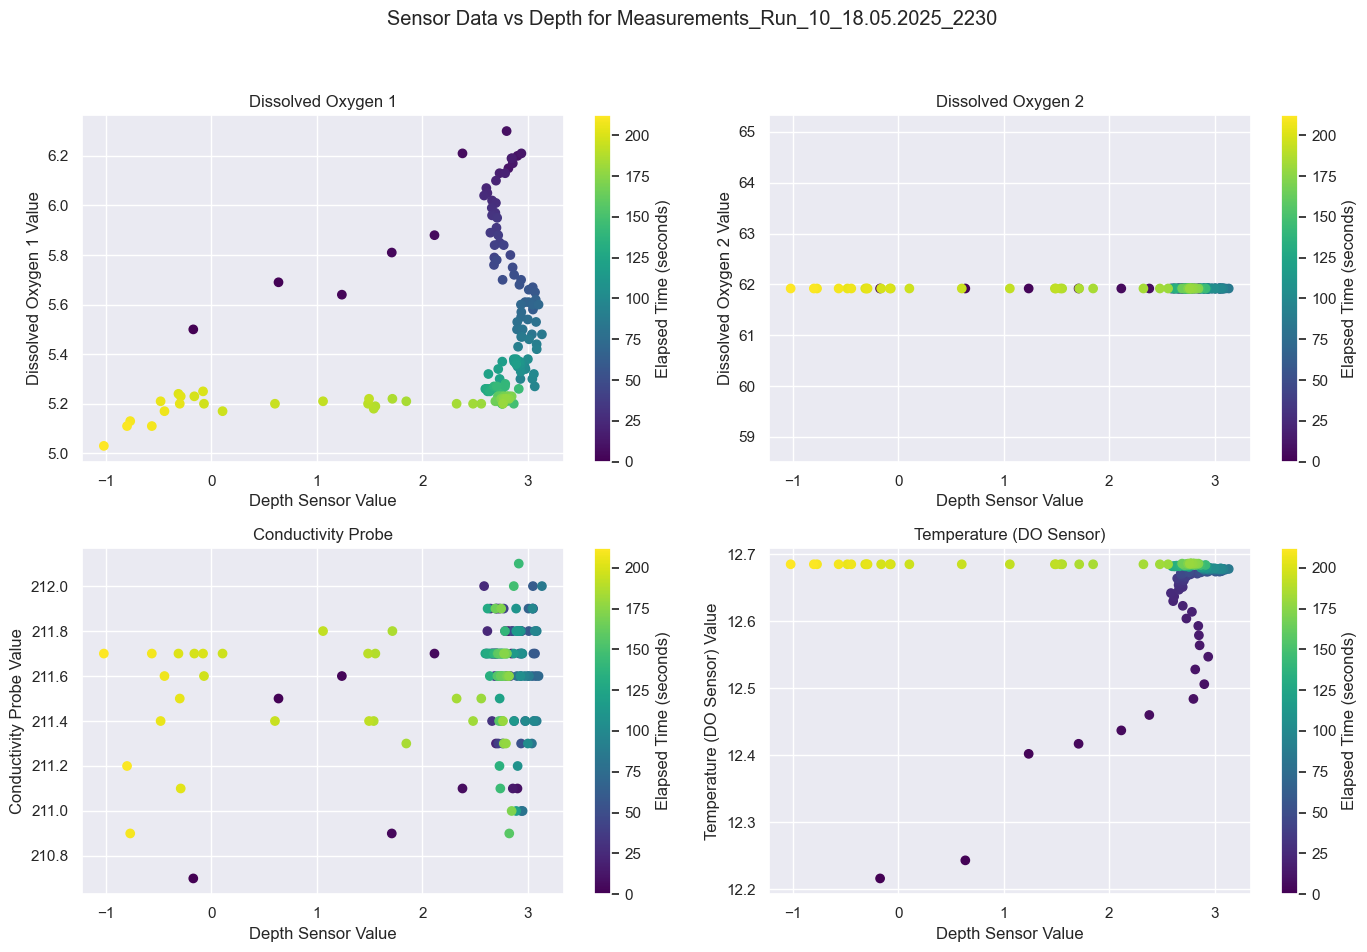

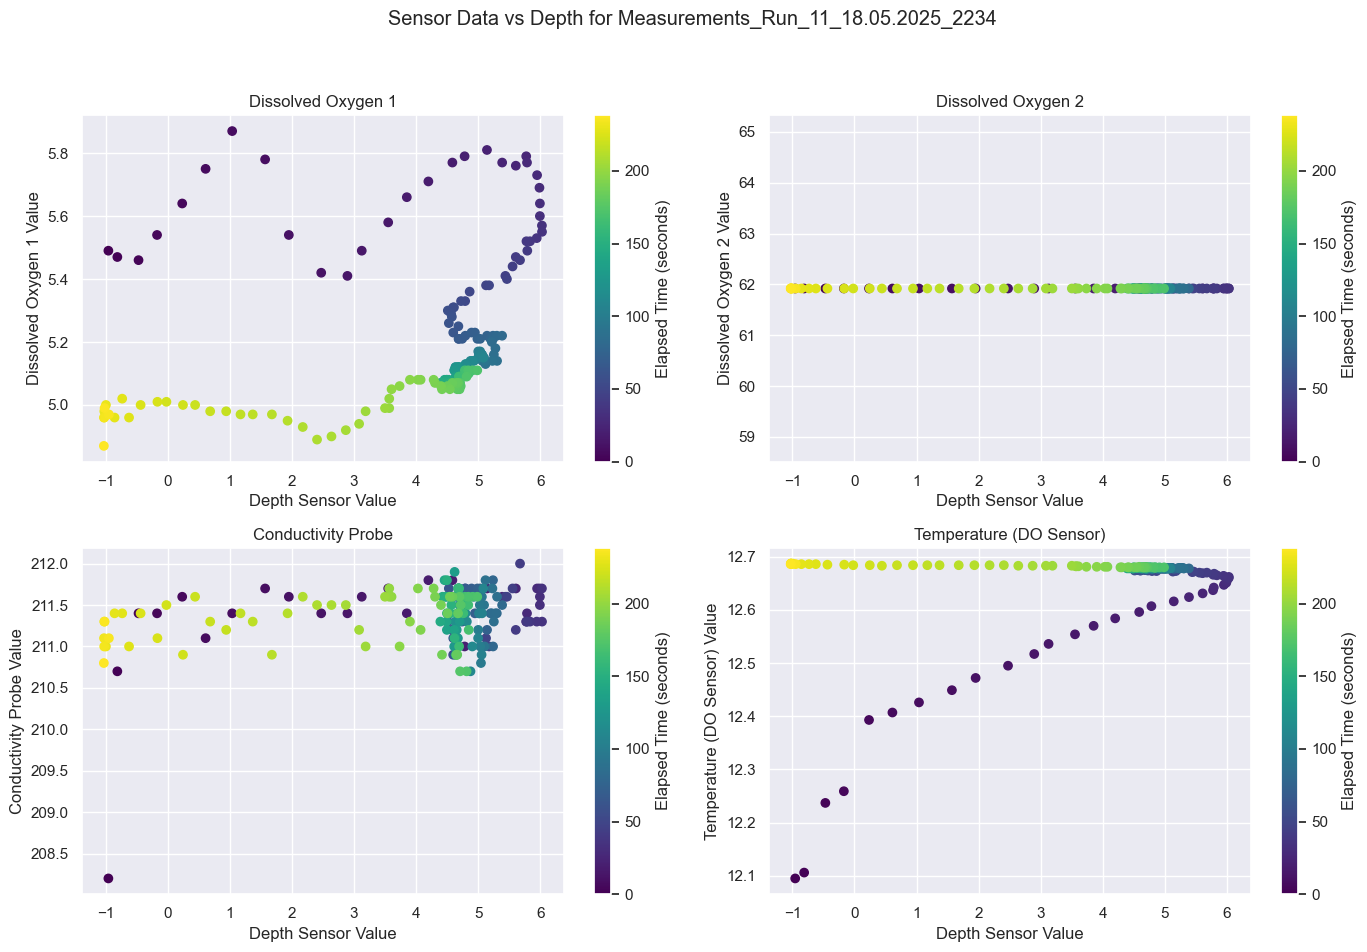

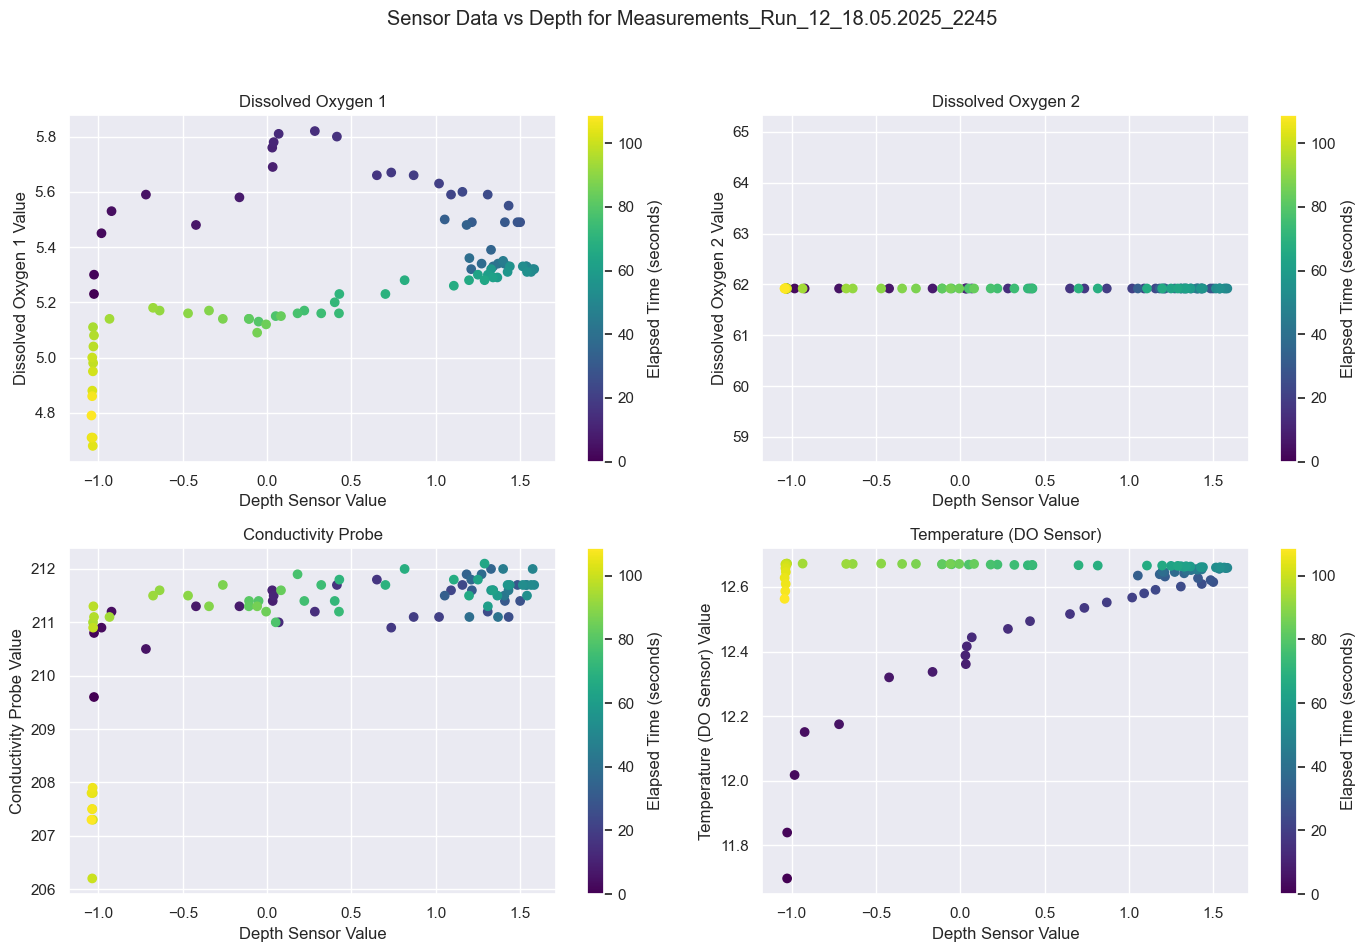

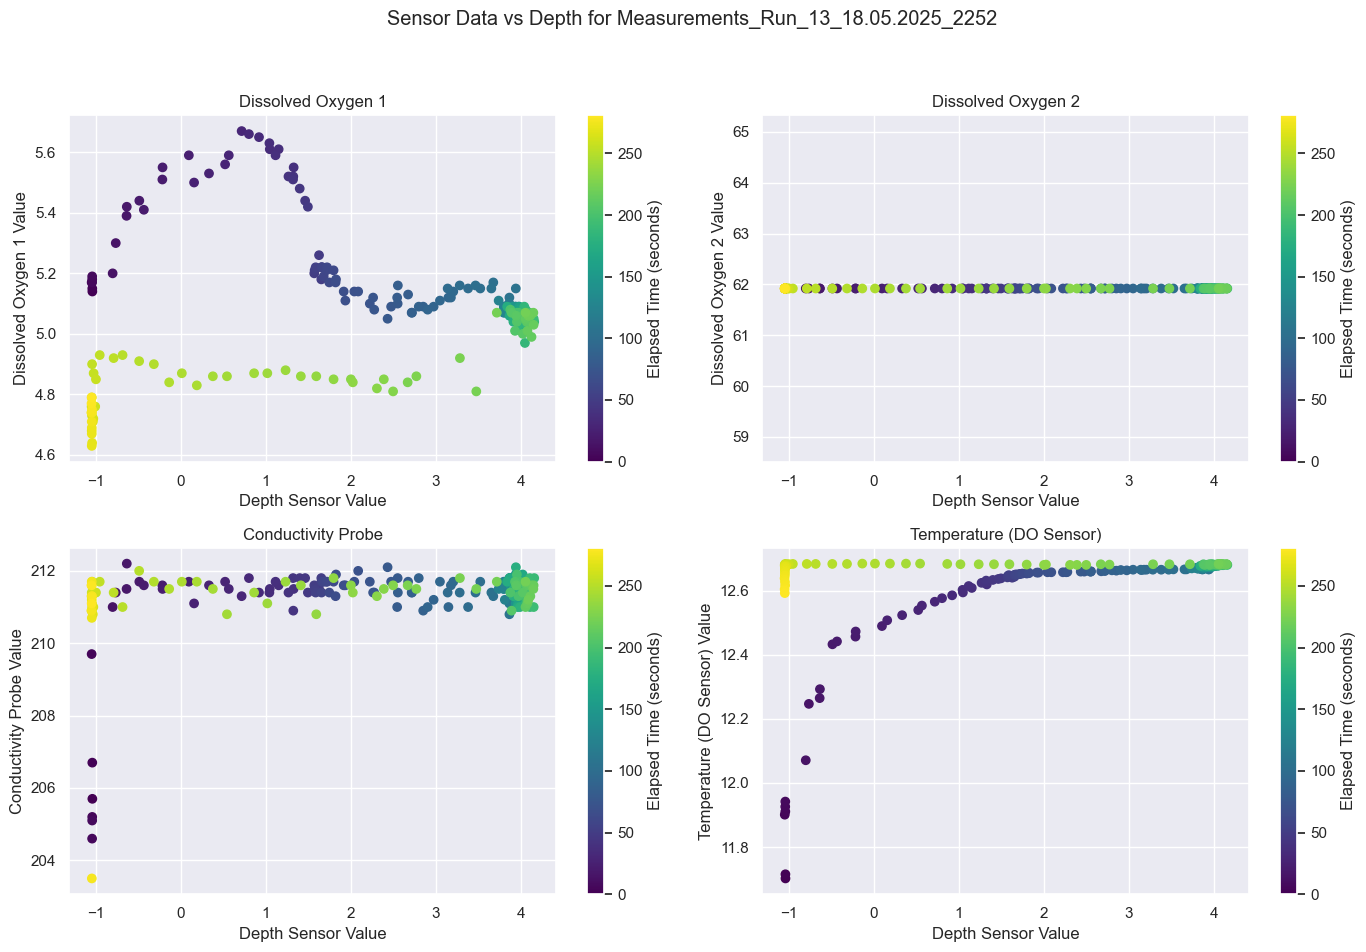

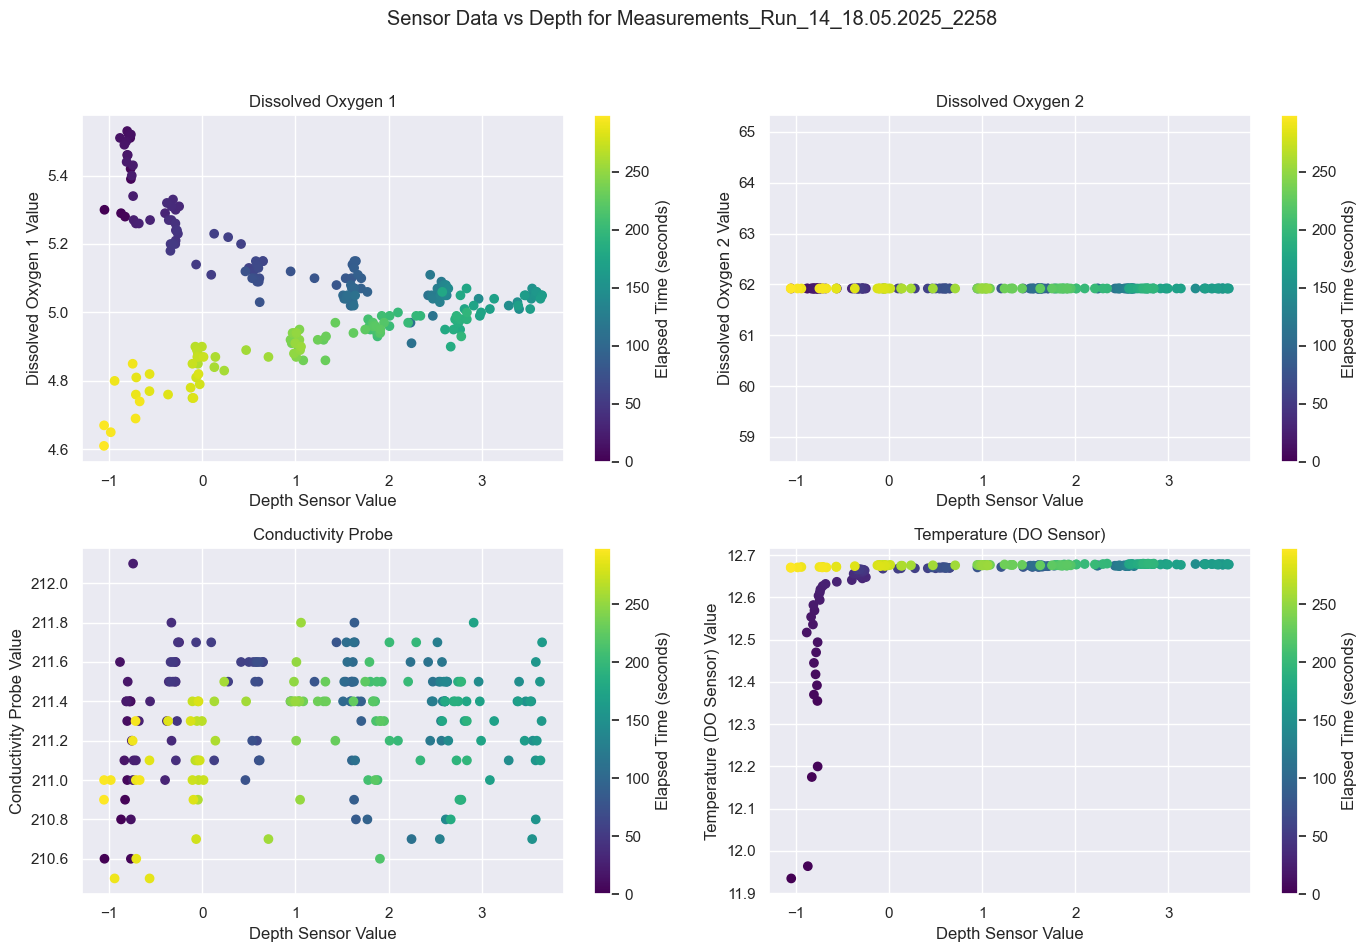

In [8]:
# now ignore the time data and plot everything in function of the depth data
# and in 4 subplots, one for each sensor except depth
# actually include the time data, but just to add a color gradient so that we know the time evolution.
#the legend of the time should be in minutes and seconds, and subtract the beginning time so that it starts at 0:00
import numpy as np
for file in csv_files:
    table_name = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file)
    # get timestamps where Conductivity Probe value is below 200
    low_cond_timestamps = df[(df['sensor_name'] == 'Conductivity Probe') & (df['value'] < 200)]['timestamp'].unique()
    # remove rows with these timestamps
    df = df[~df['timestamp'].isin(low_cond_timestamps)]
    df.to_sql(table_name, conn, index=False, if_exists='replace')
    df.to_sql(table_name, conn, index=False, if_exists='replace')
    
    # get depth data
    query_depth = f"SELECT timestamp, value FROM '{table_name}' WHERE sensor_name = 'Depth Sensor'"
    depth_df = pd.read_sql_query(query_depth, conn)
    
    # convert timestamps to elapsed time in seconds
    depth_df['elapsed_time'] = (pd.to_datetime(depth_df['timestamp']) - pd.to_datetime(depth_df['timestamp'].iloc[0])).dt.total_seconds()
    
    sensors = df['sensor_name'].unique()
    sensors = [s for s in sensors if s != 'Depth Sensor']
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()
    
    for i, sensor in enumerate(sensors):
        query = f"SELECT timestamp, value FROM '{table_name}' WHERE sensor_name = ?"
        sensor_df = pd.read_sql_query(query, conn, params=(sensor,))
        
        # merge with depth data to get corresponding depth values
        merged_df = pd.merge(sensor_df, depth_df[['timestamp', 'value', 'elapsed_time']], on='timestamp', suffixes=('_sensor', '_depth'))
        
        sc = axs[i].scatter(merged_df['value_depth'], merged_df['value_sensor'], c=merged_df['elapsed_time'], cmap='viridis')
        axs[i].set_title(sensor)
        axs[i].set_xlabel('Depth Sensor Value')
        axs[i].set_ylabel(f'{sensor} Value')
        cbar = plt.colorbar(sc, ax=axs[i])
        cbar.set_label('Elapsed Time (seconds)')
    
    plt.suptitle(f"Sensor Data vs Depth for {table_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()